# prologue

### set up notebook and load package

In [1]:
# for notebook plotting
%matplotlib inline 

# load what we need
import time
import timeit
import CHIRPS.structures as strcts
import CHIRPS.datasets as ds
import CHIRPS.datasets_proprietary as dsp
import CHIRPS.routines as rt

# demo datasets that ship with package. all from UCI unless stated otherwise
# import CHIRPS.datasets as ds
# ds.adult_data, ds.adult_samp_data, ds.adult_small_samp_data Large dataset ships with manageable sub samples
# ds.bankmark_data, ds.bankmark_samp_data
# ds.car_data
# ds.cardio_data this is the cardiotocography dataset
# ds.credit_data
# ds.german_data
# ds.lending_data, ds.lending_samp_data, ds.lending_small_samp_data, ds.lending_tiny_samp_data from Kaggle. see datasets_from_source file for links
# ds.nursery_data, ds.nursery_samp_data
# ds.rcdv_data, ds.rcdv_samp_data from US government see datasets_from_source file for links

### common config - can be ommitted if defaults are OK

In [2]:
project_dir = '/datadisk/whiteboxing/examples'
# project_dir = 'V:\\whiteboxing\\examples' # defaults to a directory "whiteboxing" in the working directory
# project_dir = 'C:\\Users\\Crutt\\Documents\\whiteboxing\\exampada'

random_state_splits = 123 # one off for splitting the data into test / train
random_state = 123 # for everything else - e.g. building a new rf with same data

# Build a Random Forest Model to Predict and Explain
First, a wrapper is created for the dataset. Use one that ships with the package, or create your own.
Then split the data into training and (hold out) test set using the convenience functions in the package. These return an object that contain the split data in various representations, such as Pandas DataFrames and encoded, sparse matrices.

In [3]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
#mydata = dsp.usoc2(random_state=random_state_splits, project_dir=project_dir)

# class imbalance
#import pandas_ml
#meta_data['get_label'](meta_data['class_col'], 4)

using previous tuning parameters
Best OOB Accuracy Estimate during tuning: 0.6693
Best parameters:{'max_depth': 32.0, 'n_estimators': 1400, 'oob_score': True, 'random_state': 123}

Confusion matrix, without normalization
[[2928  611]
 [1366  758]]


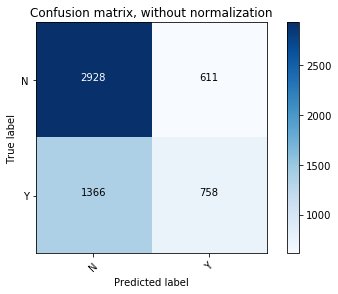

Normalized confusion matrix
[[0.83 0.17]
 [0.64 0.36]]


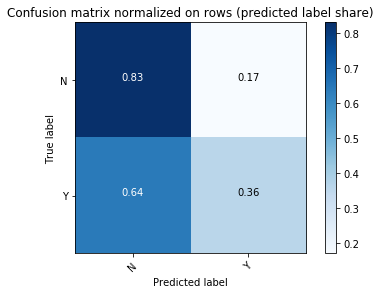

In [4]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
#mydata = dsp.usoc2(random_state=random_state_splits, project_dir=project_dir)
#mydata = ds.mhtech14(random_state=random_state_splits, project_dir=project_dir)
mydata = ds.rcdv(random_state=random_state_splits, project_dir=project_dir)

meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

# split the data. here using a basic sampling method.
# the returned object is a wrapper class that contains
# the train and test splits for X and y

# also the the encoded versions of X_train and X_test that the rf will use
# this is because we prefer onehot encoded over allowing categorical vars to be represented as integer
# scikit would treat these as ordinal, which is inappropriate

# also some meta-data: priors for y, the indexes from the input data

# also some convenience functions for leave-one-out testing

# train test split - one off hard-coded random state.
# random state can be ommitted 
# and will default to the state held in the dataset container
# which defaults to 123 if ommitted in the constructor
train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# build model, tuned for high accuracy
model = 'RandomForest'
# model = 'AdaBoost1'
# model = 'AdaBoost2'
# model = 'GBM'

# decide if to run the whole tuning routine again (long for Adaboost)
# RF routine has a default tuning grid, so can leave as None, or come up with some other options
tuning = {'grid' : None, 'override' : False}
if model == 'RandomForest':
    which_trees = 'majority'
    tuning.update({'grid' : None}) # defaults to n_trees [200, 400, ..., 1600]

elif model in ('AdaBoost1', 'AdaBoost2'):
    if model == 'AdaBoost1':
        # classic (and multi-class) AdaBoost
        algo = 'SAMME'
        which_trees = 'majority'
    else:
        algo = 'SAMME.R'
        which_trees = 'conf_weighted'
    max_depth = [i for i in range(1, 5)]
    tuning.update({'grid' : {'base_estimator' : [rt.DecisionTreeClassifier(max_depth=d) for d in max_depth],
                            'n_estimators': [(i + 1) * 200 for i in range(8)], 'algorithm': [algo]}})
    
else: # GBM - not fully implemented yet
    stop # ValueError

rf = rt.forest_prep(ds_container=tt,
                    meta_data=meta_data,
                    # override_tuning=True,
                    model=model,
                    tuning_grid=tuning['grid'],
                    save_path=save_path,
                    plot_cm=True, plot_cm_norm=True)

# Preparing unseen data

Again note:
test set has never been "seen" by random forest during training
test set has been only used to assess model (random forest) accuracy - no additional tuning after this
test set has not be involved in generating the explainer

## optional: memory and computation cost management
#### CHIRPS is time economical but memory intensive to compute for lots of instances at once
option 1: choose a smaller number of instances to explain

In [5]:
# control for async processes - each tree walk can be done in its own core
# and so can each explanation (e.g. rule conditions merge by hill-climbing)
# these will default to false if not passed explicitly to the explainer function
# on a multi-core machine there should be a good speed up for large batches
# when the batch_size advantage exceeds the overhead of setting up multi-processing
# timings will be printed to screen so you can see if it helps
forest_walk_async=True
chirps_explanation_async=True

# how many instances to explain in total from a test/unseen set
# doesn't matter if you don't know how large the dataset is
# this function prevents you maxing out, or put n_instances = None for whole dataset
n_instances = rt.n_instance_ceiling(ds_container=tt, n_instances=20)

# this gets the next batch out of the data_split_container according to the required number of instances
# all formats can be extracted, depending on the requirement
# unencoded, encoded (sparse matrix is the type returned by scikit), ordinary dense matrix also available
# tt.current_row_test = 0
instances, _, instances_enc, instances_enc_matrix, labels = tt.get_next(n_instances, which_split='test') # default

option 2: just run the whole test set

In [6]:
# instances = tt.X_test; instances_enc = tt.X_test_enc; instances_enc_matrix = tt.X_test_enc_matrix; labels = tt.y_test

## Make predictions from the decision forest on the unseen data
Important point, no compromise on model accuracy

In [7]:
# get all the model predictions for the test instance(s) we're looking at
preds_idx = labels.index
preds = rf.predict(X=instances_enc)

# CHIRPS Step 1:
## Extract Tree Prediction Paths
### Fit a forest_walker object to the dataset and decision forest
This is a wrapper will extracts the paths of all the given instances. For CHIRPS, we want a large sample. The whole training set or other representative sample will do.

It can also report interesting statistics (treating the forest as a set of random tree-structured variables).

In [8]:
# wrapper object needs the decision forest itself and the dataset meta data (we have a convenience function for this)
f_walker = strcts.forest_walker(forest = rf, meta_data=meta_data)

Now the work of extracting all the paths for each instance is done

In [9]:
print('Walking forest for ' + str(len(labels)) + ' instances... (please wait)')

# set the timer
forest_walk_start_time = timeit.default_timer()

# do the walk - creates a paths_container (even for just one instance) as a new property
# requires the X instances in a matrix (dense, ordinary numpy matrix) - this is available in the data_split_container
f_walker.forest_walk(instances = instances_enc_matrix
                    , labels = preds # we're explaining the prediction, not the true label!
                    , forest_walk_async = forest_walk_async)

# stop the timer
forest_walk_end_time = timeit.default_timer()
forest_walk_elapsed_time = forest_walk_end_time - forest_walk_start_time

print('Forest Walk with async = ' + str(forest_walk_async))
print('Forest Walk time elapsed:', "{:0.4f}".format(forest_walk_elapsed_time), 'seconds')

Walking forest for 20 instances... (please wait)
Forest Walk with async = True
Forest Walk time elapsed: 4.4306 seconds


# CHIRPS Steps 2-4: 
## Freqent pattern mining of paths.
## Score and sort mined path segments.
## Merge path segments into one rule.

This is a wrapper object that will execute steps 2-4 on all the instance-paths in the batch_paths_container.

Note that true_divide warnings are OK. It just means that a continuous variable is unbounded in some way i.e. no greater/less than discontinuity is used in the CHIRPS explanation.

Note also, here we are using the training set to create the explainers. We could use a different dataset as long as it is representative of the training set that built the decision forest. Most important that we don't use the dataset that we wish to explain.

In [10]:
chirps_explanation_async=True
# get what the model predicts on the training sample
sample_labels = rf.predict(tt.X_train_enc)

# build CHIRPS and a rule for each instance represented in the path detail
CHIRPS = strcts.CHIRPS_container(f_walker.path_detail,
                                forest=rf,
                                sample_instances=tt.X_train_enc, # any representative sample can be used
                                # sample_labels=tt.y_train,  # any representative sample can be used
                                sample_labels=sample_labels,
                                meta_data=meta_data)

print('Running CHIRPS on a batch of ' + str(len(labels)) + ' instances... (please wait)')
# start a timer
ce_start_time = timeit.default_timer()

CHIRPS.batch_run_CHIRPS(target_classes=preds, # we're explaining the prediction, not the true label!
                        chirps_explanation_async=chirps_explanation_async,
                        random_state=random_state,
                        which_trees=which_trees,
                        alpha_paths=0.9,
                        support_paths=0.15,
                        score_func=1,
                        disc_path_bins=4,
                        merging_bootstraps=20,
                        pruning_bootstraps=20,
                        delta=0.1,
                        weighting='kldiv')

ce_end_time = timeit.default_timer()
ce_elapsed_time = ce_end_time - ce_start_time
print('CHIRPS time elapsed:', "{:0.4f}".format(ce_elapsed_time), 'seconds')
print('CHIRPS with async = ' + str(chirps_explanation_async))

Running CHIRPS on a batch of 20 instances... (please wait)
as_chirps for batch_idx 0
start mining for batch_idx 0


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


found 124 patterns from 919 for batch_idx 0
start score sort for batch_idx 0
as_chirps for batch_idx 1
start mining for batch_idx 1


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


start merge rule for batch_idx 0 (124) patterns
as_chirps for batch_idx 2
start mining for batch_idx 2


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


as_chirps for batch_idx 3
found 2283 patterns from 968 for batch_idx 1
start mining for batch_idx 3


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


start score sort for batch_idx 1


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


as_chirps for batch_idx 4
start mining for batch_idx 4


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


found 5266 patterns from 721 for batch_idx 2
start score sort for batch_idx 2
as_chirps for batch_idx 5
start mining for batch_idx 5


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


found 821 patterns from 987 for batch_idx 4
start score sort for batch_idx 4
as_chirps for batch_idx 6
start mining for batch_idx 6
found 3445 patterns from 925 for batch_idx 3


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


start score sort for batch_idx 3


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


found 361 patterns from 943 for batch_idx 5
start score sort for batch_idx 5
as_chirps for batch_idx 7
start mining for batch_idx 7


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


start merge rule for batch_idx 5 (361) patterns
found 281 patterns from 1174 for batch_idx 7
start score sort for batch_idx 7
found 1180 patterns from 1091 for batch_idx 6
start merge rule for batch_idx 4 (821) patterns
start score sort for batch_idx 6
as_chirps for batch_idx 8
start mining for batch_idx 8


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


start merge rule for batch_idx 7 (281) patterns
as_chirps for batch_idx 9
start mining for batch_idx 9


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


found 105 patterns from 784 for batch_idx 8
start score sort for batch_idx 8
start merge rule for batch_idx 8 (105) patterns
start merge rule for batch_idx 1 (2283) patterns
found 1457 patterns from 1171 for batch_idx 9
start score sort for batch_idx 9
start merge rule for batch_idx 6 (1180) patterns
0.8151951911081905 2 0 0.11988490404888379 0.11352805534204455
start merge rule for batch_idx 9 (1457) patterns
[('age', True, 246.92397), ('priors', False, 0.375)]
merge complete for batch_idx 0
start get explainer for batch_idx 0
as_chirps for batch_idx 10
start mining for batch_idx 10


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


start merge rule for batch_idx 3 (3445) patterns
found 1602 patterns from 782 for batch_idx 10
start score sort for batch_idx 10
0.9559367183074551 3 34 0.10856452322206919 0.10092434374285217
start merge rule for batch_idx 2 (5266) patterns
0.7618796465097798 5 0 0.06401777607686097 0.08554107305244012
[('age', False, 256.75), ('age', False, 575.03571), ('priors', True, 1.69582), ('rule', True, 1.05614)]
merge complete for batch_idx 7
start get explainer for batch_idx 7
start merge rule for batch_idx 10 (1602) patterns
[('priors', True, 11.20489)]
merge complete for batch_idx 8
start get explainer for batch_idx 8
as_chirps for batch_idx 11
start mining for batch_idx 11


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


as_chirps for batch_idx 12
start mining for batch_idx 12


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


found 310 patterns from 1216 for batch_idx 12
start score sort for batch_idx 12
start merge rule for batch_idx 12 (310) patterns
0.7914097139087065 1 0 0.0653312932238043 0.07169751893369991
[('priors', True, 2.87858), ('tservd', True, 28.39559), ('white', False, 0.375)]
merge complete for batch_idx 5
start get explainer for batch_idx 5
as_chirps for batch_idx 13
start mining for batch_idx 13


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


found 227 patterns from 941 for batch_idx 13
start score sort for batch_idx 13
start merge rule for batch_idx 13 (227) patterns
found 28885 patterns from 826 for batch_idx 11
start score sort for batch_idx 11
0.8046340055090944 1 0 0.062098881970041896 0.06365852804964815
0.9082404480749894 1 0 0.1562613872140391 0.1561888468343899
[('age', False, 391.6125), ('priors', True, 3.42275)]
merge complete for batch_idx 4
start get explainer for batch_idx 4
[('male', True, 0.5), ('priors', True, 0.98969), ('rule', True, 1.06046), ('white', False, 0.375)]
merge complete for batch_idx 12
start get explainer for batch_idx 12
as_chirps for batch_idx 14
start mining for batch_idx 14


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


as_chirps for batch_idx 15
start mining for batch_idx 15


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


found 963 patterns from 736 for batch_idx 14
start score sort for batch_idx 14
found 662 patterns from 865 for batch_idx 15
start score sort for batch_idx 15
start merge rule for batch_idx 15 (662) patterns
start merge rule for batch_idx 14 (963) patterns
0.87840091392957 2 0 0.10610621772355068 0.10079467371362048
[('priors', True, 1.04217), ('rule', True, 0.89204)]
merge complete for batch_idx 9
start get explainer for batch_idx 9
as_chirps for batch_idx 16
start mining for batch_idx 16


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


found 250 patterns from 707 for batch_idx 16
start score sort for batch_idx 16
start merge rule for batch_idx 16 (250) patterns
0.9098198707313955 4 0 0.030023030342079097 0.03719701321079838
[('age', False, 640.8977), ('rule', True, 1.1126), ('priors', True, 9.7832), ('school', True, 10.05271), ('school', False, 5.12214)]
merge complete for batch_idx 13
start get explainer for batch_idx 13
as_chirps for batch_idx 17
start mining for batch_idx 17


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


found 1145 patterns from 981 for batch_idx 17
start score sort for batch_idx 17
start merge rule for batch_idx 17 (1145) patterns
0.7478079409073419 4 0 0.012938875827014569 0.013500140286619666
[('priors', True, 3.07302), ('tservd', True, 13.59771), ('tservd', False, 3.49102)]
merge complete for batch_idx 1
start get explainer for batch_idx 1
as_chirps for batch_idx 18
start mining for batch_idx 18


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


found 285 patterns from 801 for batch_idx 18
start score sort for batch_idx 18
start merge rule for batch_idx 18 (285) patterns
0.8390652771210079 5 0 0.1581922610059706 0.1289519830316876
0.8877293704026201 2 0 0.09281340402073304 0.09340958605664486
0.802351966071272 3 0 0.07856114242652243 0.0656432265874326
[('propty', True, 0.5), ('rule', True, 1.12552)]
merge complete for batch_idx 15
start get explainer for batch_idx 15
[('priors', True, 4.31088), ('rule', True, 7.78326)]
merge complete for batch_idx 16
start get explainer for batch_idx 16
[('age', False, 264.72576), ('priors', True, 1.23164)]
merge complete for batch_idx 10
start get explainer for batch_idx 10
as_chirps for batch_idx 19
start mining for batch_idx 19


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1373: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1378: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


found 275 patterns from 729 for batch_idx 19
start score sort for batch_idx 19
0.8718786734172091 2 0 0.030258640945456623 0.031376113833713914
start merge rule for batch_idx 19 (275) patterns
[('age', False, 257.68227), ('age', False, 505.55425), ('priors', True, 1.94217), ('rule', True, 0.9726)]
merge complete for batch_idx 6
start get explainer for batch_idx 6
0.7718163399739055 5 0 0.05504566713921511 0.03813577236918135
[('priors', False, 0.375), ('rule', False, 0.375), ('rule', True, 3.21317), ('married', True, 0.5), ('super', True, 0.5), ('tservd', True, 23.98919), ('person', True, 0.5), ('follow', True, 79.5117)]
merge complete for batch_idx 14
start get explainer for batch_idx 14
0.8679408882083761 4 0 0.06664054803789442 0.07914617791685294
0.8783934025500736 2 0 0.056092025962815414 0.05811018414255872
0.8217166848308569 4 0 0.05208284834734093 0.06712404503417771
[('age', False, 367.8238), ('priors', True, 5.00879)]
merge complete for batch_idx 18
start get explainer for ba

# Viewing and Evaluating CHIRPS explanations
Evaluation is done using unseen data to see how well the explanations generalise. The data_split_container object (tt) has a  leave-one-out function that is used during the routine to ensure that the datum we are explaining is excluded from the evaluation.

In [11]:
# iterate over all the test instances to determine the various scores using leave-one-out testing
print('evaluating found explanations')
print()
results_start_time = timeit.default_timer()

save_results_file = model + '_CHIRPS_rnst_' + str(random_state)

rt.evaluate_CHIRPS_explainers(CHIRPS, tt, labels.index, # for full batch runs: tt.y_test.index,
                              forest=rf,
                              meta_data=meta_data,
                              model=model,
                              eval_start_time=results_start_time,
                              print_to_screen=True, # set True when running single instances
                              eval_alt_labelings=True,
                              eval_rule_complements=True,
                              save_results_path=save_path,
                              dataset_name='test',
                              save_results_file=save_results_file,
                              save_CHIRPS=False)

results_end_time = timeit.default_timer()
results_elapsed_time = results_end_time - results_start_time
print('CHIRPS batch results eval time elapsed:', "{:0.4f}".format(results_elapsed_time), 'seconds')
# this completes the CHIRPS runs

evaluating found explanations

INSTANCE RESULTS
['instance id: 12703 with true class label: 0 (N)']

Model Results for Instance
['target (predicted) class: 1 (Y)']
target class prior (training data): 0.3766744872474079
forest vote share (unseen instance): 0.6564285714285715
forest vote margin (unseen instance): 0.3128571428571429
confidence weighted forest vote share (unseen instance): 0.6564285714285715
confidence weighted forest vote margin (unseen instance): 0.3128571428571429

rule: age <= 246.92397 AND priors > 0.375
rule cardinality: 2
Fraction of total points of rule: 0.11988490404888379
Fraction of total weight of rule: 0.11352805534204455

Estimated Results - Rule Training Sample. Algorithm: greedy_stab
rule coverage (training data): 0.007871036100809808
rule xcoverage (training data): 0.007870440441955501
rule precision (training data): 0.8365384615384616
rule stability (training data): 0.822429906542056
rule recall (training data): 0.017480409885473176
rule f1 score (trainin

AttributeError: 'numpy.int64' object has no attribute 'absolute'